# Bitcoin price prediction  

Starting a new quick project, let's try to write a time series prediction for the bitcoin price.
Let's take a small dataset from some past, try to achieve the smallest MAE for linear regression.

## 1. Import data, packets

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

data = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/BTC_5min_sample.csv",
                   parse_dates=True,
                   index_col='timestamp'
                  )

data.head()

,open,high,low,close,volume
timestamp,,,,,
2023-06-18 00:00:00,26519.10,26542.5,26501.76,26515.80,35.4498
2023-06-18 00:05:00,26508.01,26535.0,26506.13,26511.30,7.4262
2023-06-18 00:10:00,26511.30,26551.0,26508.77,26519.62,18.9461
2023-06-18 00:15:00,26519.44,26550.0,26464.43,26511.99,89.2364
2023-06-18 00:20:00,26513.33,26541.0,26414.28,26439.52,90.0204


Let's look at open price graph.

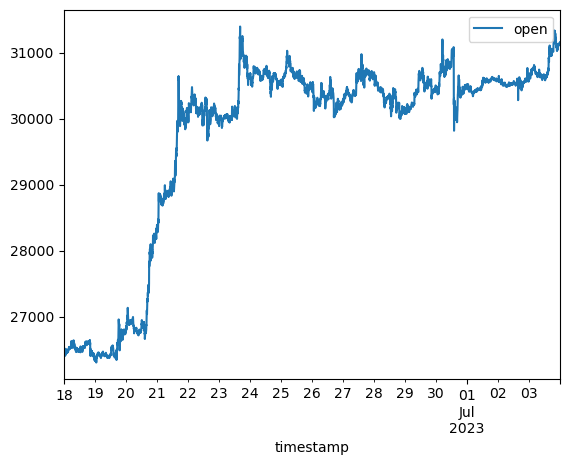

In [2]:
data = data[['open']]
data.plot();

## 2. Data Preprocessing

So prediction the open price be our goal.  
First of all we need to clean dataframe from NaN values, chech index order and create addition features.  
Let's do it at separated steps, and merge them after the check.  

### 2.1 Data checks

In [3]:
# check index for monotonic
data.index.is_monotonic_increasing

True

In [4]:
# check for NaN
data.isna().sum()

open    0
dtype: int64

### 2.2 Create additional features

In [5]:
# time lags
lag_start = 5
lag_end = 20

df_w = pd.DataFrame(data.copy())

for i in range(lag_start, lag_end):
    df_w[f'lag_{i}'] = df_w['open'].shift(i)

# delete NaN    
df_w.dropna(inplace=True)
    
df_w.head(15)

,open,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
timestamp,,,,,,,,,,,,,,,,
2023-06-18 01:35:00,26440.09,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12,26513.33,26519.44,26511.30,26508.01,26519.10
2023-06-18 01:40:00,26472.00,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12,26513.33,26519.44,26511.30,26508.01
2023-06-18 01:45:00,26457.37,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12,26513.33,26519.44,26511.30
2023-06-18 01:50:00,26459.88,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12,26513.33,26519.44
2023-06-18 01:55:00,26478.14,26450.30,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12,26513.33
2023-06-18 02:00:00,26506.00,26440.09,26450.30,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12
2023-06-18 02:05:00,26492.51,26472.00,26440.09,26450.30,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27
2023-06-18 02:10:00,26489.81,26457.37,26472.00,26440.09,26450.30,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69
2023-06-18 02:15:00,26488.21,26459.88,26457.37,26472.00,26440.09,26450.30,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93


### 3. Regreshion model